<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import random
import re 
import nltk
import torch
import transformers
import warnings

import numpy as np
import pandas as pd
import nltk

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,  cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
warnings.filterwarnings('ignore')

RANDOM_STATE = 28

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    df = pd.read_csv('C:/Users/User/Downloads/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков нет. Нужно будет очистить и лемматизировать признаки.

-------------

Посмотрим на баланс по целевому признаку:

<AxesSubplot:>

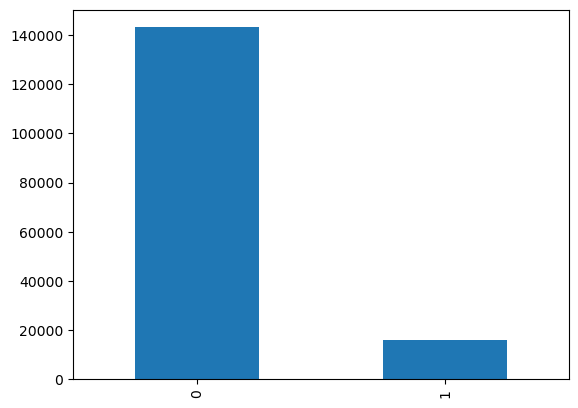

In [5]:
df['toxic'].value_counts().plot.bar()

Явно заметен дисбаланс для целевого признака.

----------------------

Напишем функцию чтобы получить очищенный и лемматизированный текст:

In [ ]:
def lemmatize_word(word, pos_tag):
    wnl = WordNetLemmatizer()
    pos_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }
    pos = pos_map.get(pos_tag[0].upper(), wordnet.NOUN)
    return wnl.lemmatize(word, pos=pos)

def clean_and_lemmatize(text):
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    lemm_list = [lemmatize_word(word, pos_tag) for word, pos_tag in tagged]
    lemm_text = " ".join(lemm_list)
    return lemm_text

df['lemm_text'] = df['text'].apply(clean_and_lemmatize)

df = df.drop(['text'], axis=1)

Разделим данные на тренировочную, валидационную и тестовую выборку размерами 70%, 15%, 15% соответственно:

In [ ]:
X = df.drop('toxic', axis=1)
y = df['toxic']

X_train, X_other, y_train, y_other = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=RANDOM_STATE
) 

X_valid, X_test, y_valid, y_test = train_test_split(
    X_other,
    y_other,
    test_size=0.5,
    random_state=RANDOM_STATE
)

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

X_train = count_tf_idf.fit_transform(X_train['lemm_text'])
X_valid = count_tf_idf.transform(X_valid['lemm_text'])
X_test = count_tf_idf.transform(X_test['lemm_text'])
print('train:', X_train.shape, y_train.shape, 'valid:', X_valid.shape, y_valid.shape, 'test:', X_test.shape, y_test.shape)


## Обучение

Обучим несколько моделей без учета дисбаланса классов и выберем лучшую:

#### LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', n_jobs=-1)
lr.fit(X_train, y_train) 
lr_predictions = lr.predict(X_valid)
print('LogisticRegression F1:', f1_score(lr_predictions, y_valid))

F1: 0.7276796816712261

#### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_valid)
print('RandomForestClassifier F1:', f1_score(rfc_predictions, y_valid))

F1: 0.7189321300996427

#### DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=10)
dtc.fit(X_train, y_train)
dtc_predictions = dtc.predict(X_valid)
print('DecisionTreeClassifier F1:', f1_score(dtc_predictions, y_valid))

F1: 0.5879732739420935

Логистическая регрессия и случайный лес показали хороший результат но время у логистической регрессии значительно превосходит случайный лес.

-----------------

Выбираем логистическую регрессию и путем подбора порога улучшим F1 нашей модели:

lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
lr.fit(X_train, y_train)
probabilities_valid = lr.predict_proba(X_train)
probabilities_one_valid = probabilities_valid[:, 1]
best_threshold = None
best_result = 0
for threshold in np.arange(0.2, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    result = f1_score(y_train, predicted_valid)
    if result > best_result:
        best_threshold = threshold
        best_result = result
print('F1:', best_result)
print('Порог:', best_threshold)

In [ ]:
from sklearn.model_selection import cross_val_predict

lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
probabilities_valid = cross_val_predict(lr, X_train, y_train, cv=5, method='predict_proba')
probabilities_one_valid = probabilities_valid[:, 1]
best_threshold = None
best_result = 0
for threshold in np.arange(0.4, 0.9, 0.1):
    predicted_valid = probabilities_one_valid > threshold 
    result = f1_score(y_train, predicted_valid)
    if result > best_result:
        best_threshold = threshold
        best_result = result
print('F1:', best_result)
print('Порог:', best_threshold)

Результат удовлетворяет на валидационной выборке.

---------------

Выясним значение метрики на тестовой выборке:

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)
lr.fit(X_train, y_train)
probabilities_test = lr.predict_proba(X_test)
threshold = best_threshold
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > threshold 
print('F1:', f1_score(y_test, predicted_test))

F1: 0.784100418410042

## Выводы

Нашей задачей было обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении был набор данных с разметкой о токсичности правок. В ходе работы очистили и лемматизировали данные. Разделили на тренировочную, валидационную и тестовыю выборки, обучили модели логистической регрессии, дерево решений и случайный лес. Выбрали лучшей логистическую регрессию, в качестве борьбы с дисбалансом классов подобрали порог и проверили модель на тестовой выборке. получили результат метрики F1 > 0.75.